In [71]:
import os
import torch
from torchvision.transforms import v2
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from torchmetrics.classification import MulticlassAccuracy, MulticlassJaccardIndex, MulticlassF1Score
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from tqdm.notebook import tqdm

In [72]:
classes_df = pd.read_csv("Camvid/class_dict.csv")
classes = torch.tensor(classes_df[["r", "g", "b"]].values, dtype=torch.uint8)

In [78]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_names = sorted(os.listdir(image_dir))
        self.label_names = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        label_path = os.path.join(self.label_dir, self.label_names[idx])
        image = decode_image(img_path)[:, ::3, ::4]
        label = decode_image(label_path)[:, ::3, ::4]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        label_class = torch.empty(size=(label.shape[1], label.shape[2]), dtype=torch.long)
        label = label.permute(1, 2, 0)
        for class_idx, rgb in enumerate(classes):
            label_class[(label == rgb).all(dim=-1)] = class_idx

        return image, label_class, label

In [79]:
transform = v2.Compose([
    # v2.Resize((256, 256), interpolation=v2.InterpolationMode.NEAREST),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
label_transform = v2.Compose([
    # v2.Resize((256, 256), interpolation=v2.InterpolationMode.NEAREST),
    v2.ToDtype(torch.uint8, scale=False)
])

In [80]:
train_dataset = SegmentationDataset(
    image_dir="CamVid/train",
    label_dir="CamVid/train_labels",
    transform=transform,
    target_transform=label_transform
)

test_dataset = SegmentationDataset(
    image_dir="CamVid/test",
    label_dir="CamVid/test_labels",
    transform=transform,
    target_transform=label_transform
)

val_dataset = SegmentationDataset(
    image_dir="CamVid/val",
    label_dir="CamVid/val_labels",
    transform=transform,
    target_transform=label_transform
)

In [81]:
# for i in range(len(test_dataset)):
#     if (zeros := torch.where(test_dataset[i][1] == 0)):
#         print(i, zeros)

In [82]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [83]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    encoder_depth = 4,
    decoder_channels = [256, 128, 64, 32],
    in_channels=3,
    classes=32
)

dice_loss = smp.losses.DiceLoss(mode='multiclass', from_logits=True, smooth=1)
ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [84]:
def loss_fn(pred, target, alpha=0.5, beta=0.5):
    dice = dice_loss(pred, target)
    ce = ce_loss(pred, target)

    return alpha * dice + beta * ce

In [85]:
def train_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    for images, labels, _ in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels, alpha=0.7, beta=0.3)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels, alpha=0.7, beta=0.3)

            epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
writer = SummaryWriter("runs/CamVid")
best_val_loss = float('inf')
num_epochs = 20
for epoch in tqdm(range(num_epochs)):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss = validate_epoch(model, val_loader, loss_fn, device)
    scheduler.step(val_loss)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(model.state_dict(), "best_model_camvid.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

writer.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 1.1220, Validation Loss: 0.8286
Epoch 2/20
Train Loss: 0.7637, Validation Loss: 0.6901
Epoch 3/20
Train Loss: 0.6904, Validation Loss: 0.6791
Epoch 4/20
Train Loss: 0.6670, Validation Loss: 0.6126
Epoch 5/20
Train Loss: 0.6298, Validation Loss: 0.5952
Epoch 6/20
Train Loss: 0.5965, Validation Loss: 0.5912
Epoch 7/20
Train Loss: 0.5546, Validation Loss: 0.5777
Epoch 8/20
Train Loss: 0.5236, Validation Loss: 0.5923
Epoch 9/20
Train Loss: 0.4891, Validation Loss: 0.5831
Epoch 10/20
Train Loss: 0.4663, Validation Loss: 0.5336
Epoch 11/20
Train Loss: 0.4476, Validation Loss: 0.4987
Epoch 12/20
Train Loss: 0.4106, Validation Loss: 0.4821
Epoch 13/20
Train Loss: 0.3796, Validation Loss: 0.4736
Epoch 14/20
Train Loss: 0.3723, Validation Loss: 0.4778
Epoch 15/20
Train Loss: 0.3467, Validation Loss: 0.4636
Epoch 16/20
Train Loss: 0.3313, Validation Loss: 0.4551
Epoch 17/20
Train Loss: 0.3249, Validation Loss: 0.4624
Epoch 18/20
Train Loss: 0.3167, Validation Loss: 0.4595
E

In [95]:
iou_metric = MulticlassJaccardIndex(num_classes=classes.shape[0], average=None).to(device)
accuracy_metric = MulticlassAccuracy(num_classes=classes.shape[0], average=None).to(device)
dice_metric = MulticlassF1Score(num_classes=classes.shape[0], average=None).to(device)

for test_images, test_labels, _ in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    predictions = model.predict(test_images)

    iou_metric.update(predictions, test_labels)
    accuracy_metric.update(predictions, test_labels)
    dice_metric.update(predictions, test_labels)

# print(f"Accuracy: {accuracy_metric.compute():.4f}")
# print(f"IoU: {iou_metric.compute():.4f}")
# print(f"dice_metric: {dice_metric.compute():.4f}")
print(f"Accuracy: {accuracy_metric.compute()}")
print(f"IoU: {iou_metric.compute()}")
print(f"dice_metric: {dice_metric.compute()}")

Accuracy: 0.4156
IoU: 0.3448
dice_metric: 0.4455


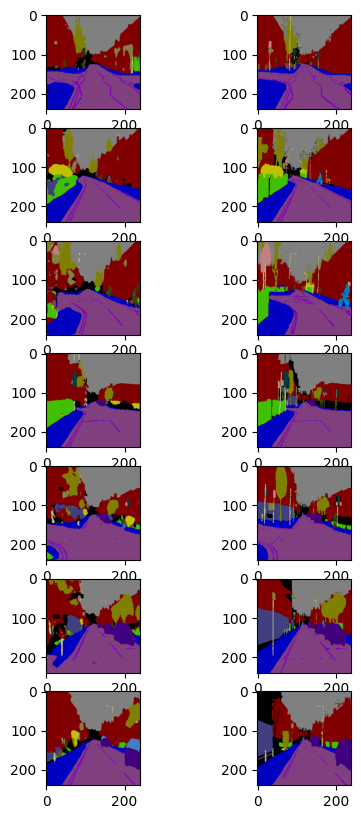

In [104]:
classes = classes.to('cpu')
class_predictions = torch.argmax(predictions, dim=1).to('cpu')
fig, ax = plt.subplots(class_predictions.shape[0], 2)
fig.set_size_inches(20, 10)
for i, pixel_class in enumerate(class_predictions):
    image = classes[pixel_class]
    # ax[i, 2].imshow(plt.imread(os.path.join(test_dataset.image_dir, test_dataset.image_names[-32+i])))
    ax[i, 1].imshow(test_dataset[-class_predictions.shape[0]+i][2])
    ax[i, 0].imshow(image)